In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



In [3]:
train_df = pd.read_csv("/content/final_train.csv")
test_df  = pd.read_csv("/content/final_test.csv")

X_train = train_df["text"].values
y_train = train_df["label"].values
X_test  = test_df["text"].values
y_test  = test_df["label"].values

print("Train size:", len(X_train))
print("Test size:", len(X_test))


Train size: 8796
Test size: 2200


In [4]:
tfidf_configs = {
    "UNI": (1,1),
    "BI": (2,2),
    "UNI+BI": (1,2)
}


In [5]:
base_models = {
    "NB": MultinomialNB(alpha=0.1),
    "SVM": SVC(kernel="linear", probability=True, random_state=42),
    "RF": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
}


In [6]:
stacking_models = {
    "Stack-LR": LogisticRegression(max_iter=1000),
    "Stack-RF": RandomForestClassifier(n_estimators=100, random_state=42),
    "Stack-SVM": SVC(kernel="linear", probability=True)
}


In [7]:
from sklearn.model_selection import cross_validate, KFold


# Define the metrics you want to track during K-Fold
scoring_metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
results=[]
def evaluate_with_cv(model, Xtr, Xte, name, tfidf_name):
    # 1. K-Fold Cross-Validation (on Training Data only)
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    cv_results = cross_validate(model, Xtr, y_train, cv=kf, scoring=scoring_metrics)

    # 2. Final Fit and Test (on separate Unseen Test Data)
    start = time.time()
    model.fit(Xtr, y_train)
    train_time = time.time() - start
    pred = model.predict(Xte)

    # Append results including both CV averages and Final Test scores
    results.append({
        "TFIDF": tfidf_name,
        "Model": name,
        "CV_Accuracy_Mean": np.mean(cv_results['test_accuracy']),
        "CV_Accuracy_Std": np.std(cv_results['test_accuracy']),
        "Final_Test_Accuracy": accuracy_score(y_test, pred),
        "Final_Test_F1": f1_score(y_test, pred, average="weighted"),
        "Train_Time": train_time
    })




In [9]:
for name, ngram in tfidf_configs.items():
    print(f"\nTF-IDF: {name}")

    vectorizer = TfidfVectorizer(
        ngram_range=ngram,
        max_features=8000,
        min_df=2,
        max_df=0.95,
        sublinear_tf=True
    )

    Xtr = vectorizer.fit_transform(X_train)
    Xte = vectorizer.transform(X_test)

    # Indented 4 spaces
    for mname, model in base_models.items():
        evaluate_with_cv(model, Xtr, Xte, mname, name)

    # Indented 4 spaces
    for sname, meta in stacking_models.items():
        stack = StackingClassifier(
            estimators=list(base_models.items()),
            final_estimator=meta,
            cv=2,
            n_jobs=-1 # Changed to -1 to speed up stacking
        )
        # Fixed: passing 'stack' and 'sname' instead of old 'model'
        evaluate_with_cv(stack, Xtr, Xte, sname, name)



TF-IDF: UNI

TF-IDF: BI

TF-IDF: UNI+BI


In [10]:
df_results = pd.DataFrame(results)
df_results.to_csv("final_results_metrics.csv", index=False)
df_results.head()


,TFIDF,Model,CV_Accuracy_Mean,CV_Accuracy_Std,Final_Test_Accuracy,Final_Test_F1,Train_Time
0,UNI,NB,0.890518,0.001214,0.886818,0.885914,0.003093
1,UNI,SVM,0.925421,0.001374,0.932727,0.932607,67.033594
2,UNI,RF,0.839131,0.007167,0.854091,0.853178,20.272740
3,UNI,Stack-LR,0.926444,0.002632,0.934091,0.933957,143.805105
4,UNI,Stack-RF,0.923261,0.002934,0.937273,0.937192,148.049019


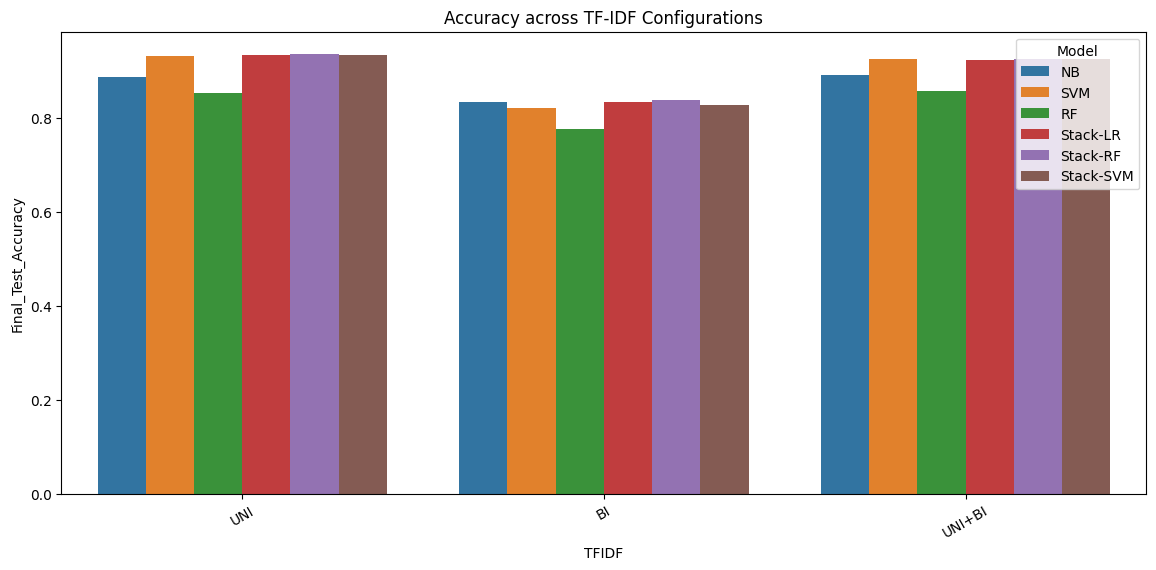

In [12]:
plt.figure(figsize=(14,6))
# Change y="Accuracy" to y="Final_Test_Accuracy" (or whatever you named the key)
sns.barplot(data=df_results, x="TFIDF", y="Final_Test_Accuracy", hue="Model")
plt.xticks(rotation=30)
plt.title("Accuracy across TF-IDF Configurations")
plt.show()


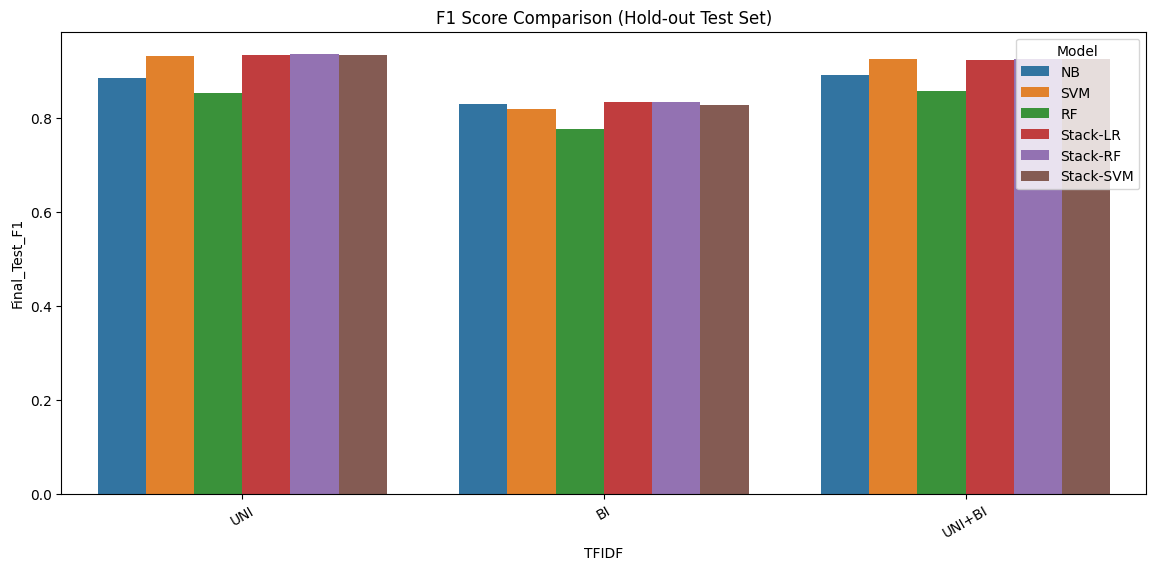

In [14]:
plt.figure(figsize=(14,6))

sns.barplot(data=df_results, x="TFIDF", y="Final_Test_F1", hue="Model")
plt.xticks(rotation=30)
plt.title("F1 Score Comparison (Hold-out Test Set)")
plt.show()


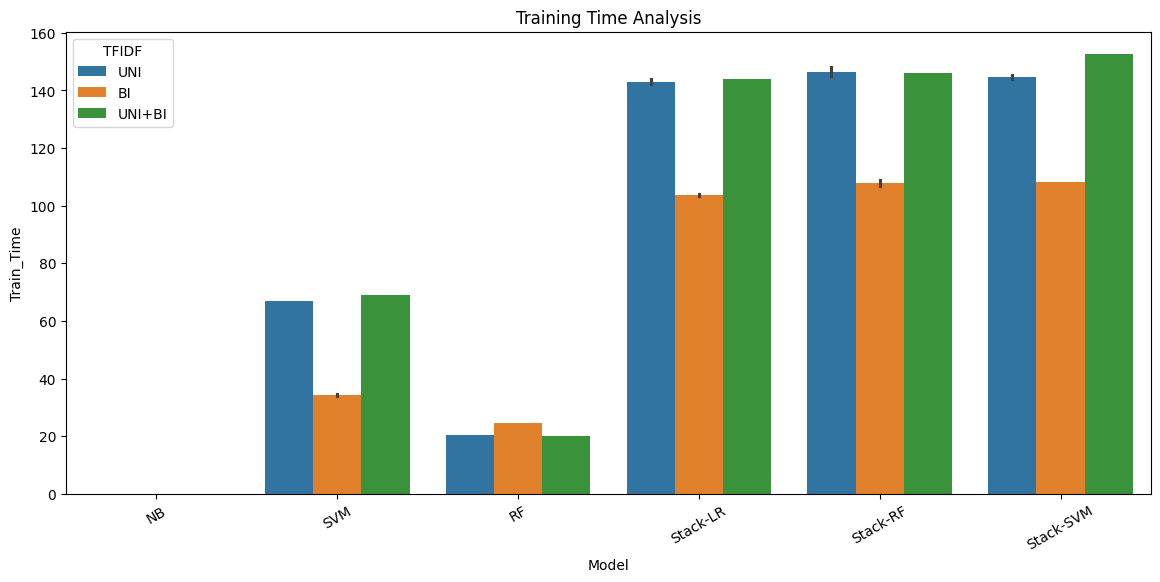

In [15]:
plt.figure(figsize=(14,6))
sns.barplot(data=df_results, x="Model", y="Train_Time", hue="TFIDF")
plt.xticks(rotation=30)
plt.title("Training Time Analysis")
plt.show()


In [18]:
# Sort by the final test score
best_row = df_results.sort_values("Final_Test_Accuracy", ascending=False).iloc[0]
print(best_row)


TFIDF                         UNI
Model                    Stack-RF
CV_Accuracy_Mean         0.923261
CV_Accuracy_Std          0.002934
Final_Test_Accuracy      0.937273
Final_Test_F1            0.937192
Train_Time             148.049019
Name: 4, dtype: object


0=negative, 2= posituve , 1=neutral


================ TF-IDF: UNI ================
Generating Confusion Matrix: Stack-LR + UNI


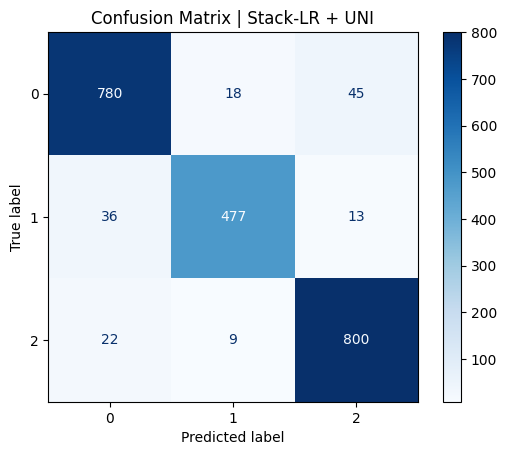

Generating Confusion Matrix: Stack-RF + UNI


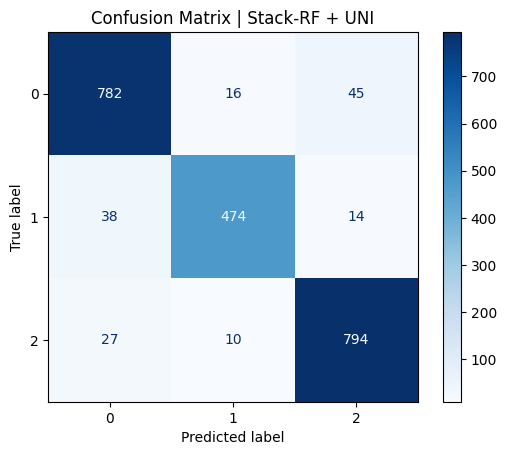

Generating Confusion Matrix: Stack-SVM + UNI


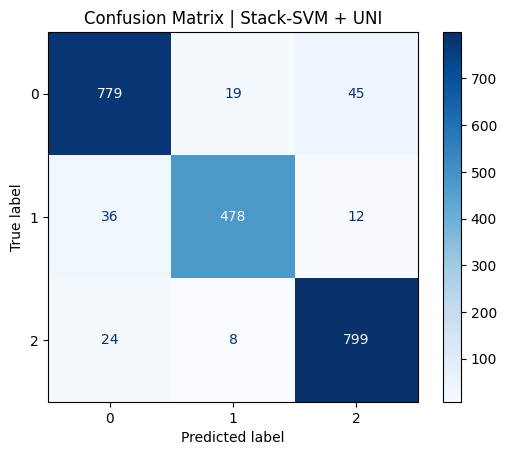


================ TF-IDF: BI ================
Generating Confusion Matrix: Stack-LR + BI


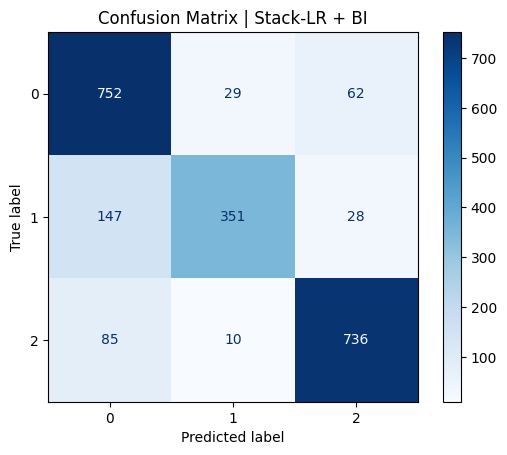

Generating Confusion Matrix: Stack-RF + BI


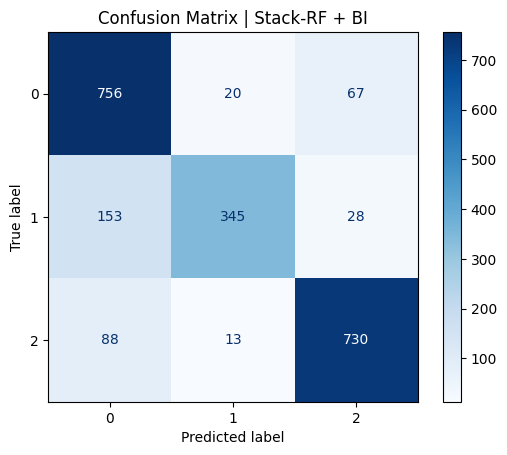

Generating Confusion Matrix: Stack-SVM + BI


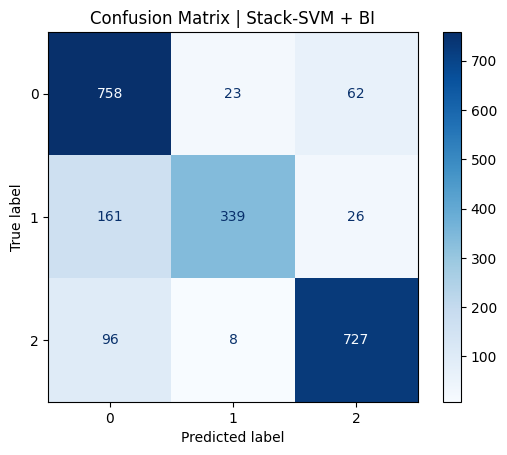


================ TF-IDF: UNI+BI ================
Generating Confusion Matrix: Stack-LR + UNI+BI


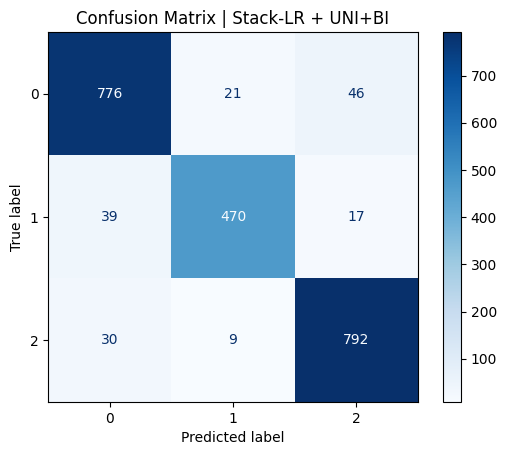

Generating Confusion Matrix: Stack-RF + UNI+BI


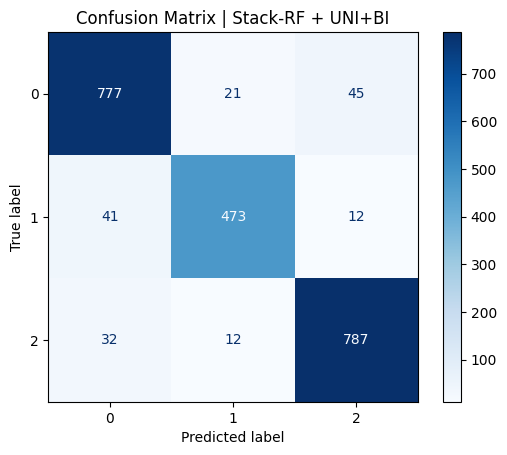

Generating Confusion Matrix: Stack-SVM + UNI+BI


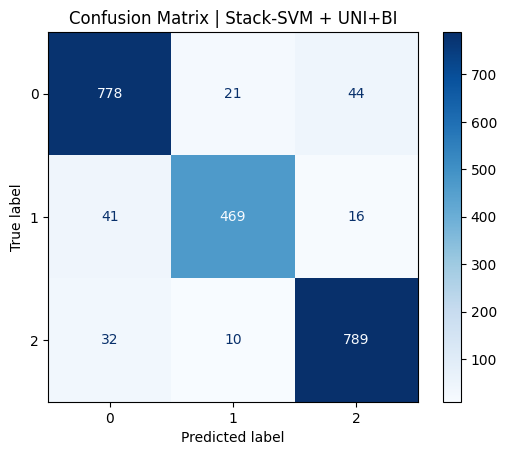

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import gc

for tfidf_name, ngram_range in tfidf_configs.items():
    print(f"\n================ TF-IDF: {tfidf_name} ================")

    vectorizer = TfidfVectorizer(
        ngram_range=ngram_range,
        max_features=8000,    
        min_df=2,
        max_df=0.95,
        sublinear_tf=True
    )

    Xtr = vectorizer.fit_transform(X_train)
    Xte = vectorizer.transform(X_test)

    for stack_name, meta_model in stacking_models.items():
        print(f"Generating Confusion Matrix: {stack_name} + {tfidf_name}")

        stack_model = StackingClassifier(
            estimators=list(base_models.items()),
            final_estimator=meta_model,
            cv=3,
            n_jobs=1
        )

        stack_model.fit(Xtr, y_train)
        y_pred = stack_model.predict(Xte)

        cm = confusion_matrix(y_test, y_pred)

        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues", values_format="d")
        plt.title(f"Confusion Matrix | {stack_name} + {tfidf_name}")
        plt.grid(False)
        plt.show()

        gc.collect()
